In [4]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import PIL
import time

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, accuracy_score, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.model_selection import train_test_split
import joblib

In [124]:
def trainRF(df_total, splitsNumber, nEstimators, clfName, avgName):
    df_total = df_total[['Celula_ID', 'Mean', 'Brightness', 'target', 'contrast',
       'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']]
    df_total
    df_total_sinCellID = df_total.drop('Celula_ID', axis=1)
    
    # Array con los distintos atributos para despues guardarlos en un .txt con su
    # importancia en la clasificaciòn
    features=np.array(df_total_sinCellID.columns.tolist())
    features = np.delete(features, 2)
    X=df_total_sinCellID.drop('target', axis=1)
    y=df_total_sinCellID[['target']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    start = time.time()

    kf = StratifiedKFold(n_splits=splitsNumber, shuffle=True)

    lista_cohen_kappa=[]
    cohen_kappa=0
    ponderacion_atributos=np.zeros((features.shape[0]+2,2),dtype='U25')

    for train_ix, valid_ix in kf.split(X_train,y_train):

        #selecciona filas
        train_X, valid_X = X_train.iloc[train_ix], X_train.iloc[valid_ix]
        train_y, valid_y = y_train.iloc[train_ix], y_train.iloc[valid_ix]

        ###############################################################    
        # Algoritmo RANDOM_FOREST para cada par de sets (TRAIN / VALID):
        ###############################################################

        #Create a Gaussian Classifier
        clf=RandomForestClassifier(n_estimators=nEstimators,class_weight='balanced',n_jobs=5,criterion='gini')

        # entreno al modelo clf.fit(X_train,y_train)    
        clf.fit(train_X,train_y.values.ravel())

        pred_y=clf.predict(valid_X)

        # Kappa de Cohen & accuracy
        ck = cohen_kappa_score(valid_y.values.ravel(),pred_y.ravel())
        lista_cohen_kappa.append(ck)

        #seleccion del modelo y guardado
        if ck > cohen_kappa:
            cohen_kappa = ck
            conf_matrix = confusion_matrix(valid_y,pred_y)

            #guardo el modelo
            joblib.dump(clf, ('TrainedModels_Data/RF_clasificador_muestras_gps_'+clfName+'.sav'))

            #ordeno los atributos por su importancia y los guardo en un txt 
            importances = clf.feature_importances_
            orden= np.flip((np.argsort(importances)),axis=0)
            ponderacion_atributos[0]=('cohen_Kappa',round(ck,4))
            ponderacion_atributos[2:]=np.array((features[orden],np.round(importances[orden],4))).T

    ponderacion_atributos[1]=('promedio_cohen_Kappa',round(np.average(lista_cohen_kappa),4))  
    np.savetxt(('FeatureImportance_Data/ponderacion_atributos_'+avgName+'.txt'),ponderacion_atributos,fmt='%s', delimiter='---')

    #Graficar y guardar la matriz de confusión
    np.savetxt(('ConfusionMatrix_Data/_CONF_MATRIX_'+clfName+'.txt'),conf_matrix,fmt='%i')

    end = time.time()
    print('ENTRENAMIENTO '+ str((end - start)/60))
    print(np.array(lista_cohen_kappa),cohen_kappa)
    
    return clf, X_test, y_test

def testRF(clf, X_test, y_test):
    # TEST
    pred_y_test=clf.predict(X_test)
    cohen_kappa_score_test = cohen_kappa_score(y_test.values.ravel(),pred_y_test.ravel())
    accuracy = accuracy_score(y_test.values.ravel(),pred_y_test.ravel())
    print("cohen kappa :"+str(cohen_kappa_score_test))
    print("accuracy :"+str(accuracy))
    conf_matrix_test = confusion_matrix(y_test, pred_y_test, labels=clf.classes_)
    print(conf_matrix_test)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test,
                                   display_labels=clf.classes_)
    disp.plot()
    plt.xticks(rotation=30)
    plt.show()
    
    return cohen_kappa_score_test, accuracy, conf_matrix_test, pred_y_test

def visualizePrediction(cellNumber,df_total, X_test,cellNameFile, path, trat, target, pred_y_test, predByModel):
    df_pred = df_total.iloc[X_test.index]
    
    if(predByModel):
        df_pred=df_pred.drop('target', axis=1)
        df_pred['target']=pred_y_test
    
    cell = os.listdir(path)[cellNumber]+'/'
    cellcode = cell[0:8]

    img = [cv2.imread(path+cell+file, cv2.IMREAD_UNCHANGED) for file in os.listdir(path+cell) if file.endswith(".tif")]
    # remove first 10 images
    del img[:10]

    # convert img from list to np.array
    img = np.array(img)

    # mean of each pixel
    img_mean = np.mean(img, axis=0)

    df_nucleo = df_pred[(df_pred['Celula_ID']==cellNameFile) & (df_pred['target']==target)]
    mask = np.full(img_mean.shape, False)
    mask = mask.flatten()
    mask[df_nucleo.index%65536] = True

    mask_reshape = np.reshape(mask, (256, 256,1)).astype('uint8')
    mask_reshape = np.repeat(mask_reshape, 3, axis=2)
    
    img_mean_reshape = np.reshape(img_mean, (256, 256,1)).astype('uint8')
    img_mean_reshape = np.repeat(img_mean_reshape, 3, axis=2)
    
    mask = mask_reshape > 0
    mascara_nucleo = mask_reshape*[255,0,150]
    img_mean_reshape[mask] = mascara_nucleo[mask]
    
    return img_mean_reshape

def visualize(cellNumber,df_total, X_test,cellNameFile, path, trat, target, pred_y_test,fileName):
    img_truth = visualizePrediction(cellNumber,df_total, X_test,cellNameFile, path, trat, target, pred_y_test, False)
    img_pred = visualizePrediction(cellNumber,df_total, X_test,cellNameFile, path, trat, target, pred_y_test, True)
    
    plt.figure()
    fig, ((ax0, ax1)) = plt.subplots(1, 2)
    fig.suptitle(cellNameFile[:6]+'_'+target)
    fig.tight_layout()
    
    ax0.imshow(img_truth,cmap = 'gray')
    ax0.set_title('Ground truth')
    ax1.imshow(img_pred,cmap = 'gray')
    ax1.set_title('Predicted')

    fig.set_size_inches(8, 4)
    for ax in fig.get_axes():
        ax.label_outer()
    
    plt.savefig('img/Predictions_vs_GroundTruth/'+cellNameFile[:6]+'_'+target+'_'+fileName+'.png', format='png', dpi=96, bbox_inches='tight', pad_inches=0)
    

# Lectura de los datos generados

In [42]:
df_total_GR = pd.read_csv('Celulas_RF/df_final/GR_atributos.csv')
df_total_tetra = pd.read_csv('Celulas_RF/df_final/GFPGRtetra_GR_atributos.csv')
df_total_cort = pd.read_csv('Celulas_RF/df_final/CORT_GR_atributos.csv')

In [97]:
df_total_withoutArray = df_total_GR
df_total_withArray = pd.concat([df_total_cort,df_total_tetra], ignore_index=True) # onlyWithArray
df_total_all = pd.concat([df_total_cort,df_total_tetra,df_total_GR], ignore_index=True)

# Entrenamiento y testeo

ENTRENAMIENTO 4.848812647660574
[0.94807466 0.94662026 0.94746534 0.94638265 0.94884928 0.94741807
 0.94719366 0.9445892  0.94573073 0.94807608] 0.9488492800585727
cohen kappa :0.9456460929898381
accuracy :0.9643625920294713
[[147254   4497   3198]
 [  2448 102399      1]
 [  2935      0 104270]]


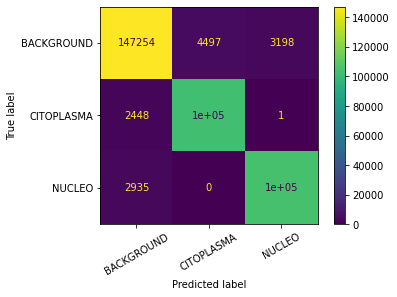

In [10]:
clf_withoutArray, X_test_withoutArray, y_test_withoutArray = trainRF(df_total_withoutArray, 10, 100, "withoutArray", "withoutArray")
# TEST
cohen_kappa_withoutArray, accuracy_withoutArray, conf_matrix_withoutArray, pred_y_test_withoutArray = testRF(clf_withoutArray, X_test_withoutArray,y_test_withoutArray)

ENTRENAMIENTO 11.592742319901784
[0.88555921 0.88931681 0.88574375 0.88645296 0.88817847 0.88669264
 0.8908149  0.88733647 0.88661837 0.88662226] 0.8908148994881273
cohen kappa :0.8884840531777236
accuracy :0.9295705159505209
[[   310     77      0     28]
 [    53 317928  15895  17531]
 [     0  13460 129729     22]
 [     0   8314      8 283077]]


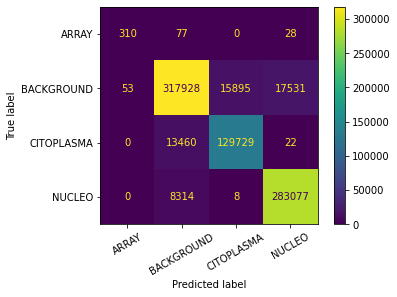

In [99]:
clf_withArray, X_test_withArray, y_test_withArray = trainRF(df_total_withArray, 10, 100, "withArray", "withArray")
# TEST
cohen_kappa_withArray, accuracy_withArray, conf_matrix_withArray, pred_y_test_withArray = testRF(clf_withArray, X_test_withArray,y_test_withArray)

ENTRENAMIENTO 18.676416031519572
[0.8435982  0.84438696 0.84361189 0.84268629 0.8438473  0.84349194
 0.84545687 0.84210744 0.84230508 0.84399809] 0.8454568722689833
cohen kappa :0.8438159412853597
accuracy :0.8994775600511169
[[   292     88      0     42]
 [    34 445983  31456  27893]
 [     0  26865 211648   9767]
 [     0  12508   7293 379565]]


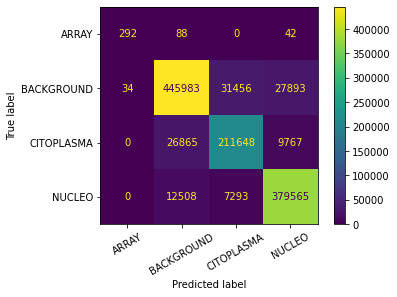

In [112]:
clf_all, X_test_all, y_test_all = trainRF(df_total_all, 10, 100, "all", "all")
# TEST
cohen_kappa_all, accuracy_all, conf_matrix_all, pred_y_test_all = testRF(clf_all, X_test_all,y_test_all)

# Visualizacion y contraste

<Figure size 432x288 with 0 Axes>

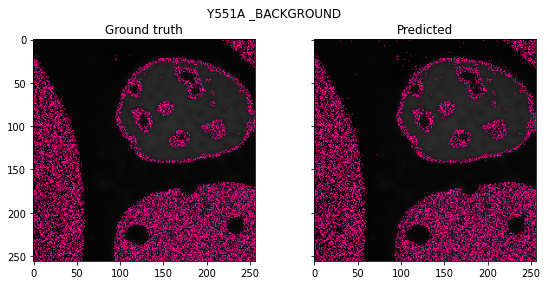

<Figure size 432x288 with 0 Axes>

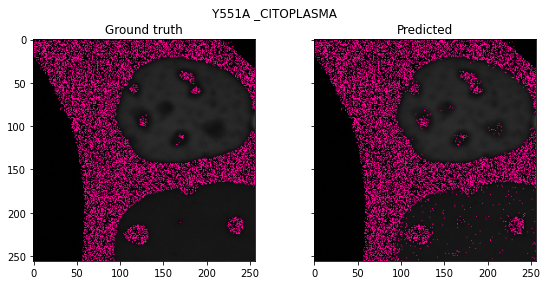

<Figure size 432x288 with 0 Axes>

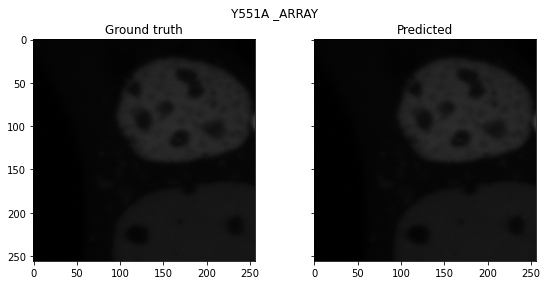

<Figure size 432x288 with 0 Axes>

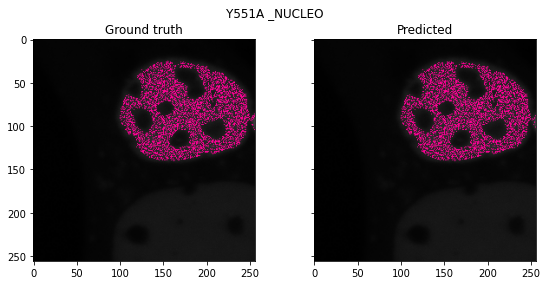

In [125]:
path = '/home/bruno/Documents/UBA/Reconocimiento de patrones/data TP-final/GPFGRY551A/'
trat = 'GR_'
visualize(8,df_total_withoutArray, X_test_withoutArray,'Y551A 06.oif.files/', path, trat, 'BACKGROUND', pred_y_test,'withoutArray')
visualize(8,df_total_withoutArray, X_test_withoutArray,'Y551A 06.oif.files/', path, trat, 'CITOPLASMA', pred_y_test,'withoutArray')
visualize(8,df_total_withoutArray, X_test_withoutArray,'Y551A 06.oif.files/', path, trat, 'ARRAY', pred_y_test,'withoutArray')
visualize(8,df_total_withoutArray, X_test_withoutArray,'Y551A 06.oif.files/', path, trat, 'NUCLEO', pred_y_test,'withoutArray')

<Figure size 432x288 with 0 Axes>

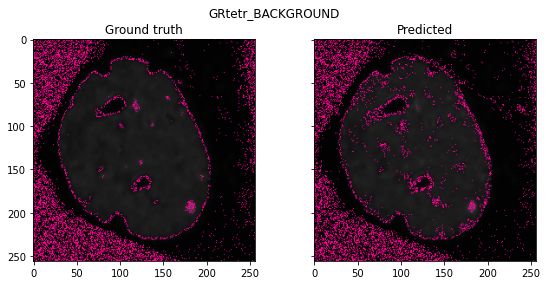

<Figure size 432x288 with 0 Axes>

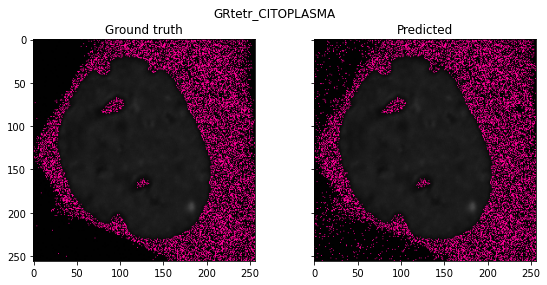

<Figure size 432x288 with 0 Axes>

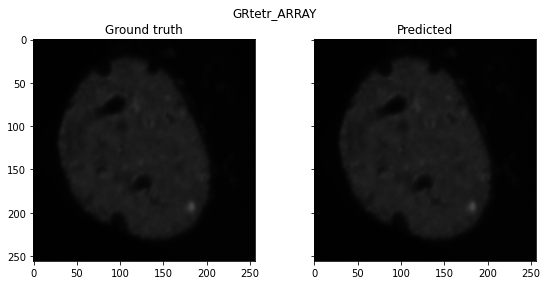

<Figure size 432x288 with 0 Axes>

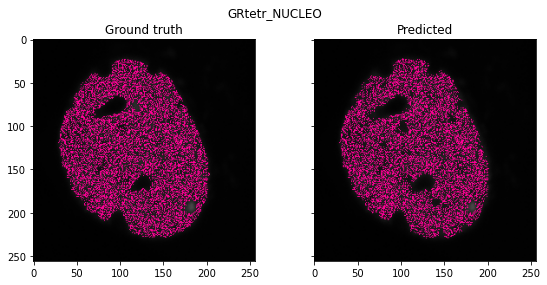

In [126]:
path = '/home/bruno/Documents/UBA/Reconocimiento de patrones/data TP-final/GFPGRtetra/'
trat = 'GR_'
visualize(2,df_total_withArray, X_test_withArray,'GRtetra 05.oif.files/', path, trat, 'BACKGROUND', pred_y_test_withArray,'withArray')
visualize(2,df_total_withArray, X_test_withArray,'GRtetra 05.oif.files/', path, trat, 'CITOPLASMA', pred_y_test_withArray,'withArray')
visualize(2,df_total_withArray, X_test_withArray,'GRtetra 05.oif.files/', path, trat, 'ARRAY', pred_y_test_withArray,'withArray')
visualize(2,df_total_withArray, X_test_withArray,'GRtetra 05.oif.files/', path, trat, 'NUCLEO', pred_y_test_withArray,'withArray')

<Figure size 432x288 with 0 Axes>

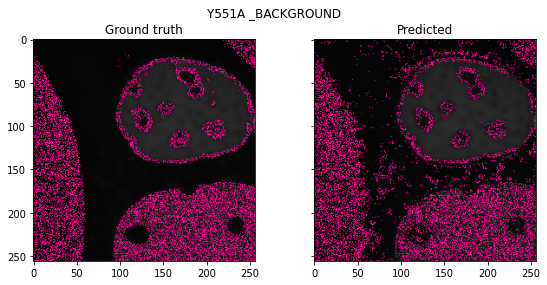

<Figure size 432x288 with 0 Axes>

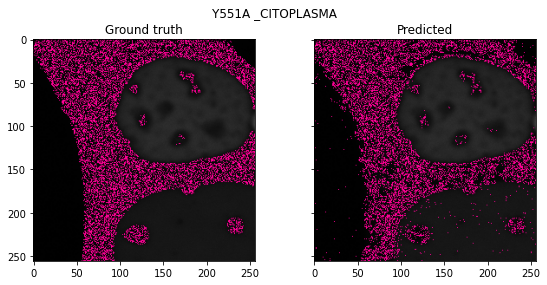

<Figure size 432x288 with 0 Axes>

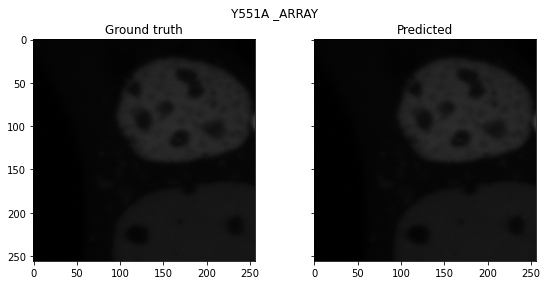

<Figure size 432x288 with 0 Axes>

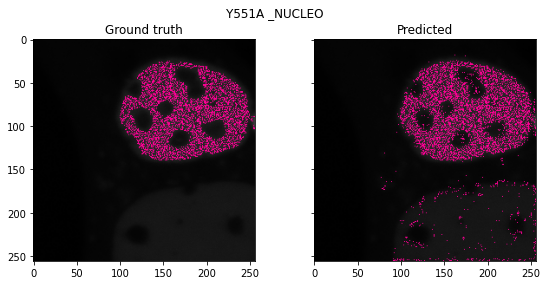

In [127]:
path = '/home/bruno/Documents/UBA/Reconocimiento de patrones/data TP-final/GPFGRY551A/'
trat = 'GR_'
visualize(8,df_total_all, X_test_all,'Y551A 06.oif.files/', path, trat, 'BACKGROUND', pred_y_test_all,'ALL')
visualize(8,df_total_all, X_test_all,'Y551A 06.oif.files/', path, trat, 'CITOPLASMA', pred_y_test_all,'ALL')
visualize(8,df_total_all, X_test_all,'Y551A 06.oif.files/', path, trat, 'ARRAY', pred_y_test_all,'ALL')
visualize(8,df_total_all, X_test_all,'Y551A 06.oif.files/', path, trat, 'NUCLEO', pred_y_test_all,'ALL')

<Figure size 432x288 with 0 Axes>

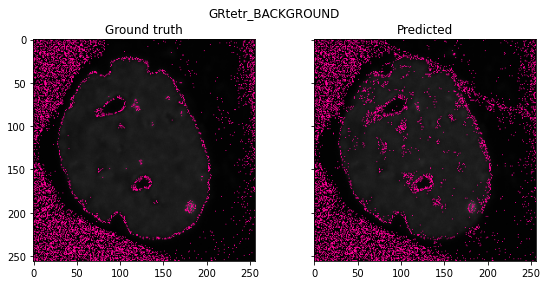

<Figure size 432x288 with 0 Axes>

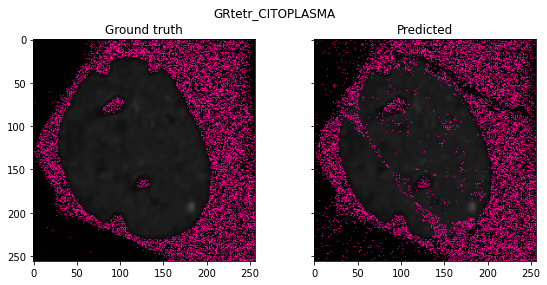

<Figure size 432x288 with 0 Axes>

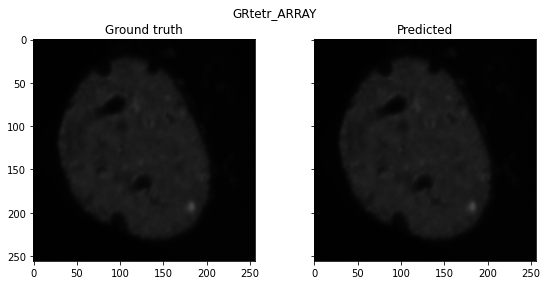

<Figure size 432x288 with 0 Axes>

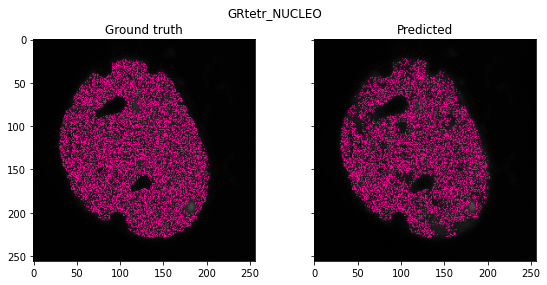

In [128]:
path = '/home/bruno/Documents/UBA/Reconocimiento de patrones/data TP-final/GFPGRtetra/'
trat = 'GR_'
visualize(2,df_total_all, X_test_all,'GRtetra 05.oif.files/', path, trat, 'BACKGROUND', pred_y_test_all,'ALL')
visualize(2,df_total_all, X_test_all,'GRtetra 05.oif.files/', path, trat, 'CITOPLASMA', pred_y_test_all,'ALL')
visualize(2,df_total_all, X_test_all,'GRtetra 05.oif.files/', path, trat, 'ARRAY', pred_y_test_all,'ALL')
visualize(2,df_total_all, X_test_all,'GRtetra 05.oif.files/', path, trat, 'NUCLEO', pred_y_test_all,'ALL')